In [1]:
!python3 --version

Python 3.10.14


In [2]:
!pip install pyqubo openjij

In [7]:
!which pip

/Users/aaaaa/.pyenv/versions/3.10.14/bin/pip


In [180]:
from pyqubo import Array, Placeholder, solve_ising, Constraint, SubH, Model, Binary
import re, random, math
import numpy as np
import openjij as oj
import time 

In [181]:
# resourceに番号を割り当てる
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [182]:
# resource_m = {'R0':['m11','m12'],'R1':['m21','m22','m23'],'R2':['m31','m32','m33','m34','m35','m36']}
# resource_t = {'R0':['t11','t21','t31','t41'],'R1':['t12','t22','t32','t42'],
#               'R2':['t13','t23','t33','t43']}

# place = [['p11','p12','p13','p14'],['p21','p22','p23','p24'],['p31','p32','p33','p34'],['p41','p42','p43','p44']]

# job = [['t11','t12','t13'],['t21','t22','t23'],['t31','t32','t33'],['t41','t42','t43']]

# machine_processing_time = {'m11':1,'m12':2,'m21':3,'m22':1,'m23':2,'m31':1,'m32':3,'m33':2,
#                           'm34':2,'m35':1,'m36':2}

# machine_cost = {'m11':10,'m12':14,'m21':13,'m22':10,'m23':10,'m31':12,'m32':10,'m33':9,
#                           'm34':12,'m35':14,'m36':15}

# import random

# # Machine keys
# machine_keys = ['m11', 'm12', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33', 'm34', 'm35', 'm36']

# # Generate random processing times and costs
# machine_processing_time = {key: random.randint(1, 3) for key in machine_keys}  
# machine_cost = {key: random.randint(9, 15) for key in machine_keys}  

# print("Machine Processing Time:", machine_processing_time)
# print("Machine Cost:", machine_cost)

# resource_num = assign_resource_num(resource_m)

# resource_num

In [183]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs, seed=None):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []
    job_tasks = {}  # タスク長を格納する辞書

    # シードを設定（指定された場合のみ）
    if seed is not None:
        random.seed(seed)

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

        # 各タスクに1から10の範囲でランダムなタスク長を割り当てる
        job_tasks[t11] = random.randint(1, 10)  # t11にランダムなタスク長を割り当て
        job_tasks[t12] = random.randint(1, 10)  # t12にランダムなタスク長を割り当て
        job_tasks[t13] = random.randint(1, 10)  # t13にランダムなタスク長を割り当て

    return resource_t, place, job, job_tasks

In [184]:
resource_m = {'R0': ['m11', 'm12'], 'R1': ['m21', 'm22'], 'R2': ['m31', 'm32']}
machine_processing_time = {'m11': 1, 'm12': 2, 'm21': 3, 'm22': 1, 'm31': 1, 'm32': 3}
machine_cost = {'m11': 10, 'm12': 14, 'm21': 13, 'm22': 10, 'm31': 12, 'm32': 10}

resource_num = assign_resource_num(resource_m)

resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [185]:
# ジョブ数を指定して生成
num_jobs = 5
resource_t, place, job, job_tasks = generate_jobs_and_resources(num_jobs, seed=42)
time = 30

In [186]:
job

[['t11', 't12', 't13'],
 ['t21', 't22', 't23'],
 ['t31', 't32', 't33'],
 ['t41', 't42', 't43'],
 ['t51', 't52', 't53']]

In [187]:
# トランジションに番号を割り当てる
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14}

In [188]:
t_num = len(transition_num)
r_num = len(resource_num)
time = 30
x = Array.create('x', (time,t_num,r_num), 'BINARY') # binaryの宣言

## Binary変数
x(時間,トランジション,マシーン)

In [189]:
def cal_min_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最小を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最小時間を求める
    """
    min_m_time = []
    for idx,v in enumerate(resource_m):
        _min = 10000
        for i in resource_m[v]:
            _min = min(_min,machine_processing_time[i])
        min_m_time.append(_min)
    return min_m_time

In [190]:
def cal_max_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最大を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最大時間を求める
    """
    max_m_time = []
    for idx,v in enumerate(resource_m):
        _min = -1
        for i in resource_m[v]:
            _min = max(_min,machine_processing_time[i])
        max_m_time.append(_min)
    return max_m_time

In [191]:
def calc_upper_limit(step, jobs, limit_time, _max):
    """
    現在のステップにおける処理時間の上限時間の計算
    Args:
        step : 現在のステップ
        jobs : 各jobのタスクのリスト
        limit_time : 制限時間
        _max : 各リソースマシーンのprocessing timeの最大値のリスト(max_list)

    Returns:
    現在のステップの上限時間を求める
    """
    p_time = 0
    for job in jobs: #jobはstr型
        if len(job) >= 4:
            if int(job[3]) >= step:
                p_time += _max[int(job[3])-1]
        elif int(job[2]) >= step:
                p_time += _max[int(job[2])-1]
    return limit_time - p_time

In [192]:
# 各トランジションの処理時間の最大・最小値を求める
range_trantision_ptime = {}
min_list = cal_min_processing(resource_m, machine_processing_time)
max_list = cal_max_processing(resource_m, machine_processing_time)

#各タスクの下限と上限時間
#'t11': [0, 22] t11は最低0秒、最高22秒で開始しなければならない
for idx, j in enumerate(job):
    for i in range(len(j)):
        range_time = []
        lb = sum(min_list[0:i]) if i != 0 else 0
        range_time.append(lb)
        ub = calc_upper_limit(i+1, j, time, max_list)
        range_time.append(ub)
        range_trantision_ptime[j[i]] = range_time
range_trantision_ptime

{'t11': [0, 22],
 't12': [1, 24],
 't13': [2, 27],
 't21': [0, 22],
 't22': [1, 24],
 't23': [2, 27],
 't31': [0, 22],
 't32': [1, 24],
 't33': [2, 27],
 't41': [0, 22],
 't42': [1, 24],
 't43': [2, 27],
 't51': [0, 22],
 't52': [1, 24],
 't53': [2, 27]}

## H_firing

In [193]:
#制約
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):
        sigma_h_firing = 0.0
        for r in resource_m['R'+str(i)]:
            lb = range_trantision_ptime[j[i]][0]
            ub = range_trantision_ptime[j[i]][1]
            for k in range(lb,ub):
                t = transition_num['t'+str(idx+1)+str(i+1)]
                sigma_h_firing += x[k,t,resource_num[r]]
        H_firing += Constraint((1-sigma_h_firing)**2,label="one_fired_t{}{}{}".format(idx+1,i+1,resource_num[r]))

## H_conflict

In [194]:
#制約
H_conflict = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        for j1 in range(len(job)):
            t1 = transition_num[job[j1][i]]
            for j2 in range(len(job)):
                t2 = transition_num[job[j2][i]]
                if j1 != j2:
                    lb = range_trantision_ptime[job[j1][i]][0]
                    ub = range_trantision_ptime[job[j1][i]][1]
                    
                    # j1 のタスク処理時間を計算
                    task_length = job_tasks[job[j1][i]]
                    processing_time = math.ceil(task_length / machine_processing_time[r])
                    
                    for k1 in range(lb,ub):
                        fd = k1 + processing_time
                        for k2 in range(range_trantision_ptime[job[j2][i]][0],range_trantision_ptime[job[j2][i]][1]):
                            
                            if k1 <= k2 and k2 < fd:
                                H_conflict += Constraint((x[k1,t1,resource_num[r]])*(x[k2,t2,resource_num[r]]), label="conflict{}".format(t1))


## H_precedence

In [195]:
#制約
H_precedence = 0.0

for idx, j in enumerate(job):
    for i in range(len(j)):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        for r1 in resource_m['R'+str(i)]:
            if i+1 < len(j):
                for r2 in resource_m['R'+str((i+1))]:
                    t1 = transition_num['t'+str(idx+1)+str(i+1)]
                    t2 = transition_num['t'+str(idx+1)+str(i+2)]
                    
                    task_length = job_tasks['t'+str(idx+1)+str(i+1)] # 現在のタスクの長さ
                    processing_time = math.ceil(task_length / machine_processing_time[r1])
                            
                    for k1 in range(lb, ub):
                        fd = k1 + processing_time

                        for k2 in range(min(fd, time)):  # k2をtimeに制限
                            H_precedence += Constraint((x[k1,t1,resource_num[r1]])*(x[k2,t2,resource_num[r2]]), 
                                                       label="precedence{}{}{}{}".format(k1,t1,k2,t2))


## H_resourceCost

In [196]:
#目的関数
H_resourceCost = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        r_num = resource_num[r]
        rc = machine_cost[r]
        fd = machine_processing_time[r]
        for j in range(len(job)):
            lb = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
            ub = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
            t = transition_num['t'+str(j+1)+str(i+1)]
            for k in range(lb,ub):
                H_resourceCost += rc*fd*x[k,t,r_num]

## H_waitingTime

In [197]:
#目的関数
H_waitingTime = 0.0

for j in range(len(job)):
    for i in range(len(job[j])-1):
        #後のタスク
        lb1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][0]
        ub1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][1]
        t1 = transition_num['t'+str(j+1)+str(i+2)]
        #前のタスク
        lb2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
        ub2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
        t2 = transition_num['t'+str(j+1)+str(i+1)]
        for k1 in range(lb1,ub1):
            for r1 in resource_m['R'+str(i+1)]:
                r_num1 = resource_num[r1]
                for k2 in range(lb2,ub2):
                    for r2 in resource_m['R'+str(i)]:
                        fd = k2 + machine_processing_time[r2]
                        r_num2 = resource_num[r2]
                        if k1 - fd >= 0:
                            H_waitingTime += (k1 - fd) * x[k2,t2,r_num2] * x[k1,t1,r_num1]
                            

## PyQUBO

In [221]:
# ハミルトニアンを構築
A = Placeholder("A")
B = Placeholder("B")
C = Placeholder("C")
D = Placeholder("D")
E = Placeholder("E")

H = SubH(A*H_firing, "SubH1") + SubH(B*H_conflict, "SubH2") + SubH(C*H_precedence, "SubH3") + D*H_resourceCost + E*H_waitingTime

In [222]:
# モデルをコンパイル
model = H.compile()

In [341]:
#PyQUBOの場合
feed_dict = {"A": 780.0, "B": 150.0, "C": 250.0, "D": 13, "E": 50}

In [342]:
# QUBOを作成
bqm = model.to_bqm(feed_dict=feed_dict)

In [343]:
# QUBOの変数数（量子ビットの数）を確認
num_qubits = len(bqm.variables)
print(f"Number of qubits: {num_qubits}")

Number of qubits: 756


## PyQUBOからOpenJij

In [344]:
import openjij as oj

In [345]:
# アニーリング回数
num_iterations = 100

# QUBOを辞書形式に変換
qubo_dict = bqm.to_qubo()[0]

# OpenJijのSamplerを使用してQUBOを解く
sampler = oj.SASampler()

response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

# サンプリング結果をデコード
decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

# 最良のサンプルを選択
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))

In [346]:
# 最良のサンプルの各サブハミルトニアンの値を計算する関数
def calculate_subh_energy(subh, sample, feed_dict):
    """
    各サブハミルトニアンの計算
    Args:
        subh: サブハミルトニアン
        sample: 最良のサンプル
        feed_dict: ハイパーパラメータ
    Returns:
        ハミルトニアンの各項のエネルギーを計算する
    """
    subh_model = subh.compile()
    subh_qubo, subh_offset = subh_model.to_qubo(feed_dict=feed_dict)
    subh_energy = sum(subh_qubo.get((v, v), 0) * sample[v] for v in sample) #一次項の計算
    for (v1, v2), coeff in subh_qubo.items(): #二次の項の計算
        if v1 != v2:
            subh_energy += coeff * sample[v1] * sample[v2]
    return subh_energy + subh_offset

In [347]:
#目的関数のエネルギー
resource_cost = calculate_subh_energy(H_resourceCost, best_sample.sample, feed_dict)
waiting_time = calculate_subh_energy(H_waitingTime, best_sample.sample, feed_dict)

In [348]:
# デコードされた解を表示
print("Decoded Solution:")
for variable, value in best_sample.sample.items():
    print(f"{variable}: {value}")

Decoded Solution:
x[0][8][5]: 0
x[22][2][4]: 0
x[8][5][4]: 0
x[18][2][5]: 0
x[14][10][2]: 0
x[15][5][5]: 0
x[0][13][3]: 0
x[0][6][1]: 0
x[0][4][3]: 0
x[16][4][2]: 0
x[17][11][4]: 0
x[0][10][2]: 0
x[9][10][3]: 0
x[0][3][0]: 0
x[0][11][4]: 1
x[12][3][1]: 0
x[23][13][3]: 1
x[0][3][1]: 0
x[10][10][3]: 0
x[21][8][5]: 0
x[0][1][3]: 0
x[15][7][3]: 0
x[0][11][5]: 0
x[12][1][2]: 0
x[3][10][3]: 0
x[0][0][1]: 0
x[24][8][4]: 0
x[19][7][2]: 0
x[27][10][3]: 0
x[15][13][2]: 0
x[13][5][4]: 0
x[2][5][5]: 0
x[7][4][3]: 0
x[0][13][2]: 0
x[0][2][5]: 0
x[17][14][5]: 0
x[11][8][5]: 0
x[7][2][5]: 0
x[10][11][5]: 0
x[29][8][5]: 0
x[16][3][1]: 0
x[18][14][5]: 0
x[9][3][1]: 0
x[17][7][3]: 0
x[29][10][2]: 0
x[10][13][2]: 0
x[10][13][3]: 0
x[25][14][5]: 0
x[16][6][1]: 0
x[12][11][4]: 0
x[16][9][1]: 0
x[20][5][4]: 0
x[9][11][5]: 0
x[10][1][2]: 0
x[6][5][5]: 0
x[0][10][3]: 0
x[17][3][1]: 0
x[7][3][1]: 0
x[10][0][1]: 0
x[10][2][5]: 0
x[16][12][0]: 0
x[18][5][4]: 0
x[19][3][0]: 0
x[1][8][4]: 0
x[10][5][5]: 0
x[26][11

In [349]:
print("\nEnergy:")
print(best_sample.energy)

print(best_sample.constraints(only_broken=True))
print("number of broken constarint = {}".format(num_broken)) #信用できるのかわからない,手動でエネルギー計算してみる


Energy:
3930.0
{'one_fired_t423': (False, 1.0)}
number of broken constarint = 1


In [350]:
keys = [k for k, v in best_sample.sample.items() if v == 1]

In [351]:
# 正規表現
def extractVariable(s):  
    literal = re.split('[\[\]]', s)
    while '' in literal:
        literal.remove('')       
    return literal

In [352]:
ans = []

for k in keys:
    ans.append(extractVariable(k))

sort_ans = list(range(len(ans)))

for i in ans:
    sort_ans[int(i[2])] = i
    
sort_ans

[['x', '2', '0', '0'],
 ['x', '7', '1', '3'],
 ['x', '8', '2', '4'],
 ['x', '4', '3', '0'],
 ['x', '8', '4', '3'],
 ['x', '2', '5', '4'],
 ['x', '12', '6', '0'],
 ['x', '14', '7', '3'],
 ['x', '29', '8', '4'],
 ['x', '15', '9', '0'],
 ['x', '28', '10', '3'],
 ['x', '29', '11', '5'],
 ['x', '20', '12', '0'],
 ['x', '23', '13', '3'],
 ['x', '25', '14', '4'],
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [369]:
# transition_num と resource_num のキーと値を反転させる
transition_name = {v: k for k, v in transition_num.items()}
resource_name = {v: k for k, v in resource_num.items()}

# 結果を格納する辞書
task_to_resource = {}

# sort_ans を解析して、タスクとリソースの対応関係を取得
for entry in sort_ans:
    if isinstance(entry, list) and len(entry) == 4:
        _, _, task_num_str, resource_num_str = entry
        task_num = int(task_num_str)
        resource_num = int(resource_num_str)
        task_name = transition_name.get(task_num)
        resource_name_str = resource_name.get(resource_num)
        if task_name and resource_name_str:
            task_to_resource[task_name] = resource_name_str

# 結果を表示
print(task_to_resource)



{'t11': 'm11', 't12': 'm22', 't13': 'm31', 't21': 'm11', 't22': 'm22', 't23': 'm31', 't31': 'm11', 't32': 'm22', 't33': 'm31', 't41': 'm11', 't42': 'm22', 't43': 'm32', 't51': 'm11', 't52': 'm22', 't53': 'm31'}


In [353]:
from collections import OrderedDict

def calc_machine_cost(machine_processing_time,ans):
    ans_order = OrderedDict()
    _cnt = 0

    for idx in machine_processing_time.keys():
        ans_order[idx] = _cnt
        _cnt += 1

    ans_list = list(ans_order.keys())

    sum_cost = 0
    for i in ans:
        sum_cost += machine_cost[ans_list[int(i[3])]]
    return sum_cost

In [354]:
def calc_processing_time(machine_processing_time,ans):
    ans_order = OrderedDict()
    _cnt = 0

    for idx in machine_processing_time.keys():
        ans_order[idx] = _cnt
        _cnt += 1

    ans_list = list(ans_order.keys())

    max_time = 0
    for i in range(len(ans)):
        max_time = max(max_time,int(ans[i][1])+machine_processing_time[ans_list[int(ans[i][3])]])
    return max_time

In [362]:
firing = calculate_subh_energy(H_firing, best_sample.sample, feed_dict)
conflict = calculate_subh_energy(H_conflict, best_sample.sample, feed_dict)
precedence = calculate_subh_energy(H_precedence, best_sample.sample, feed_dict)

In [363]:
print(firing,conflict,precedence)

1.0 1.0 2.0


In [355]:
# print("-"*30)
# print("Machine Cost : {}".format(machine_cost))
# print("-"*30)
# print("Processing Time : {}".format(processing_time))
print("-"*30)
print("Resource Cost : {}".format(resource_cost))
print("-"*30)
print("Waiting Time : {}".format(waiting_time))
print("-"*30)

------------------------------
Resource Cost : 150.0
------------------------------
Waiting Time : 11.0
------------------------------


In [356]:
subH_list = ['SubH1','SubH2','SubH3']
is_feasible = True

for i in subH_list:
    if best_sample.subh[i] != 0:
        is_feasible = False
if is_feasible:
    print('Feasible!!')
else:
    if best_sample.subh[i] != 0:
        print("["+str(i)+"]=",best_sample.subh[i])

[SubH3]= 500.0


## 結果をガントチャートで

Task t11: Processing time = 2
Task t12: Processing time = 1
Task t13: Processing time = 5
Task t21: Processing time = 4
Task t22: Processing time = 4
Task t23: Processing time = 3
Task t31: Processing time = 2
Task t32: Processing time = 9
Task t33: Processing time = 2
Task t41: Processing time = 10
Task t42: Processing time = 7
Task t43: Processing time = 1
Task t51: Processing time = 1
Task t52: Processing time = 2
Task t53: Processing time = 4


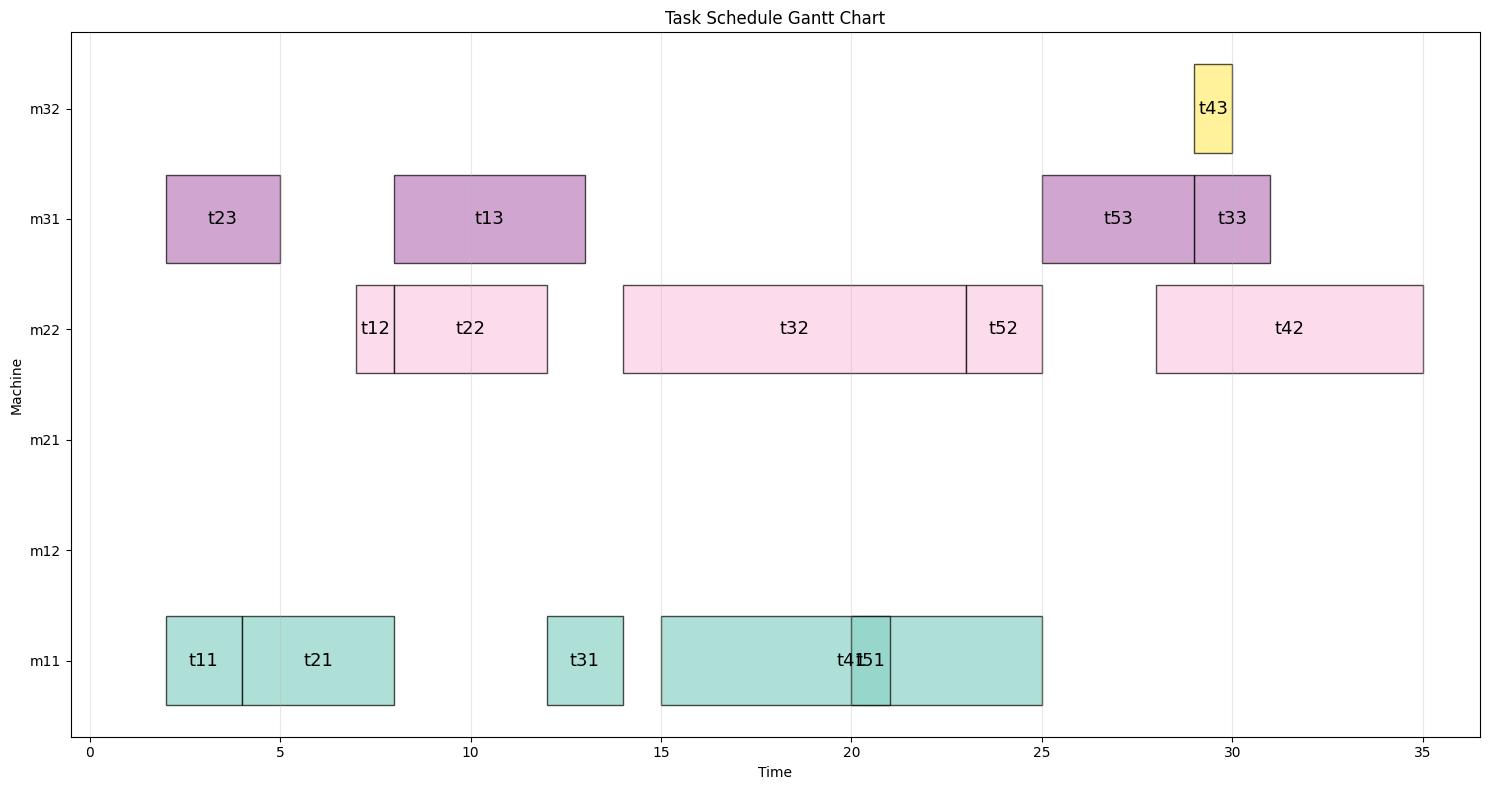

In [372]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import math

def create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time):
    # 全てのマシンリソースを取得
    all_machines = sorted(list(machine_processing_time.keys()))
    machine_to_idx = {machine: idx for idx, machine in enumerate(all_machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = task_to_resource[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_machines)))
    machine_colors = dict(zip(all_machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=13)
    
    # グラフの装飾
    ax.set_yticks(range(len(all_machines)))
    ax.set_yticklabels(all_machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# タスクスケジュールの例
fig, ax = create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time)
plt.show()


## データをcsvに保存する

In [357]:
# import csv
# import os
# from datetime import datetime

# now = datetime.now()
# timestamp = now.strftime('%Y-%m-%d')

# # 保存するファイル名
# csv_filename = f'./search/t_30/0901/{timestamp}_patt30_job{num_jobs}.csv' #任意のファイル名

# # CSVファイルが存在するかどうかを確認
# file_exists = os.path.isfile(csv_filename)

# constraint_error = best_sample.constraints(only_broken=True)
# feasible = 0 if is_feasible else constraint_error 
# #制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# # データをリストのリストとして準備
# # data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
# data = [[num_iterations, resource_cost, waiting_time, feasible]]

# # ファイルが存在しない場合はヘッダーを追加
# if not file_exists:
#     with open(csv_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
#         writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
#         writer.writerows(data)
# else:
#     # ファイルが存在する場合は追記
#     with open(csv_filename, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)

## データに対して平均と分散をplot

In [358]:
# import pandas as pd
# import numpy as np
# import re
# import glob
# import matplotlib.pyplot as plt

# # 全パターンのファイルパスを取得
# file_paths = glob.glob("../search/t_30/0901/2024-09-01_patt*_job15.csv") #任意のファイル名
# # file_paths = glob.glob("./search/t_30/2024-08-22_patt*_job15.csv")

# # 結果を保存するリスト
# all_results = []

# # 各ファイルに対して処理を適用
# for file_path in file_paths:
#     # ファイル名からパターン番号を抽出
#     patt_number = int(re.search(r'patt(\d+)', file_path).group(1))
    
#     # CSVファイルを読み込む
#     df = pd.read_csv(file_path)
    
#     # feasibleが0の行のみを選択（文字列'0'も含む）
#     df_feasible_0 = df[df['feasible'].astype(str) == '0']
    
#     # resource_cost, wating_time, feasible列を数値に変換
#     df_feasible_0['resource_cost'] = pd.to_numeric(df_feasible_0['resource_cost'], errors='coerce')
#     df_feasible_0['waiting_time'] = pd.to_numeric(df_feasible_0['waiting_time'], errors='coerce')
#     df_feasible_0['feasible'] = pd.to_numeric(df_feasible_0['feasible'], errors='coerce')
    
#     # 数値に変換できなかったデータを除外
#     df_feasible_0 = df_feasible_0.dropna(subset=['resource_cost', 'waiting_time', 'feasible'])
    
#     # iteration毎にresource_costとwating_timeの平均と分散を計算
#     summary = df_feasible_0.groupby('iteration').agg(
#         mean_resource_cost=('resource_cost', 'mean'),
#         var_resource_cost=('resource_cost', 'var'),
#         mean_waiting_time=('waiting_time', 'mean'),
#         var_waiting_time=('waiting_time', 'var'),
#     ).reset_index()
    
#     # パターン番号を追加
#     summary['patt'] = patt_number
    
#     # パターン番号とiterationを結合して新しいラベルを作成
#     summary['label'] = summary['patt'].astype(str) + "_" + summary['iteration'].astype(str)
    
#     # リストに追加
#     all_results.append(summary)
    
# # 全パターンの結果を結合
# final_df = pd.concat(all_results)

# # パターンごとに結果をソート
# final_df = final_df.sort_values(by=['patt', 'iteration'])

# final_df

In [359]:
# # resource_costをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_rc = np.sqrt(final_df['var_resource_cost'])

# plt.errorbar(final_df['label'], final_df['mean_resource_cost'], 
#              yerr=err_rc,
#              fmt='o-', color='blue', capsize=5, label='Resource Cost')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Resource Cost')
# plt.title('Average and Variance of Resource Cost by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

In [360]:
# # wating_timeをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_wt = np.sqrt(final_df['var_waiting_time'])

# plt.errorbar(final_df['label'], final_df['mean_waiting_time'], 
#              yerr=err_wt,
#              fmt='o-', color='orange', capsize=5, label='Waiting Time')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Waiting Time')
# plt.title('Average and Variance of Waiting Time by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

## パラメータDを固定しEの変えていき平均の値のデータ取得後plot

In [361]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # 読み込むCSVファイルのリスト
# csv_files = [
#     '../search/t_30/0901/final_summary_1_to_6.csv',
#     '../search/t_30/0901/final_summary_7_to_12.csv',
#     '../search/t_30/0901/final_summary_13_to_18.csv',
#     '../search/t_30/0901/final_summary_19_to_24.csv',
#     '../search/t_30/0901/final_summary_25_to_30.csv'
# ]

# # 凡例のラベルをDの値に対応させる
# legend_labels = ['D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# # カラーマップを作成（viridisカラーマップを使用）
# colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax1.plot(
#         x_indices, 
#         final_df['mean_resource_cost'], 
#         marker='o', linestyle='-', color=colors[i], 
#         label=legend_labels[i]
#     )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax2.plot(
#         x_indices, 
#         final_df['mean_waiting_time'], 
#         marker='x', linestyle='--', color=colors[i], 
#         label=legend_labels[i]
#     )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('parameter E')
# ax1.set_ylabel('resource cost')
# ax2.set_ylabel('waiting time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()